In [1]:
from datetime import datetime
from distutils.util import strtobool

import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## Loader function taken from:
## https://github.com/rakshitha123/TSForecasting/blob/master/utils/data_loader.py

# Converts the contents in a .tsf file into a dataframe and returns it along with other meta-data of the dataset: frequency, horizon, whether the dataset contains missing values and whether the series have equal lengths
#
# Parameters
# full_file_path_and_name - complete .tsf file path
# replace_missing_vals_with - a term to indicate the missing values in series in the returning dataframe
# value_column_name - Any name that is preferred to have as the name of the column containing series values in the returning dataframe
def convert_tsf_to_dataframe(
    full_file_path_and_name,
    replace_missing_vals_with="NaN",
    value_column_name="series_value",
):
    col_names = []
    col_types = []
    all_data = {}
    line_count = 0
    frequency = None
    forecast_horizon = None
    contain_missing_values = None
    contain_equal_length = None
    found_data_tag = False
    found_data_section = False
    started_reading_data_section = False

    with open(full_file_path_and_name, "r", encoding="cp1252") as file:
        for line in file:
            # Strip white space from start/end of line
            line = line.strip()

            if line:
                if line.startswith("@"):  # Read meta-data
                    if not line.startswith("@data"):
                        line_content = line.split(" ")
                        if line.startswith("@attribute"):
                            if (
                                len(line_content) != 3
                            ):  # Attributes have both name and type
                                raise Exception("Invalid meta-data specification.")

                            col_names.append(line_content[1])
                            col_types.append(line_content[2])
                        else:
                            if (
                                len(line_content) != 2
                            ):  # Other meta-data have only values
                                raise Exception("Invalid meta-data specification.")

                            if line.startswith("@frequency"):
                                frequency = line_content[1]
                            elif line.startswith("@horizon"):
                                forecast_horizon = int(line_content[1])
                            elif line.startswith("@missing"):
                                contain_missing_values = bool(
                                    strtobool(line_content[1])
                                )
                            elif line.startswith("@equallength"):
                                contain_equal_length = bool(strtobool(line_content[1]))

                    else:
                        if len(col_names) == 0:
                            raise Exception(
                                "Missing attribute section. Attribute section must come before data."
                            )

                        found_data_tag = True
                elif not line.startswith("#"):
                    if len(col_names) == 0:
                        raise Exception(
                            "Missing attribute section. Attribute section must come before data."
                        )
                    elif not found_data_tag:
                        raise Exception("Missing @data tag.")
                    else:
                        if not started_reading_data_section:
                            started_reading_data_section = True
                            found_data_section = True
                            all_series = []

                            for col in col_names:
                                all_data[col] = []

                        full_info = line.split(":")

                        if len(full_info) != (len(col_names) + 1):
                            raise Exception("Missing attributes/values in series.")

                        series = full_info[len(full_info) - 1]
                        series = series.split(",")

                        if len(series) == 0:
                            raise Exception(
                                "A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series. Missing values should be indicated with ? symbol"
                            )

                        numeric_series = []

                        for val in series:
                            if val == "?":
                                numeric_series.append(replace_missing_vals_with)
                            else:
                                numeric_series.append(float(val))

                        if numeric_series.count(replace_missing_vals_with) == len(
                            numeric_series
                        ):
                            raise Exception(
                                "All series values are missing. A given series should contains a set of comma separated numeric values. At least one numeric value should be there in a series."
                            )

                        all_series.append(pd.Series(numeric_series).array)

                        for i in range(len(col_names)):
                            att_val = None
                            if col_types[i] == "numeric":
                                att_val = int(full_info[i])
                            elif col_types[i] == "string":
                                att_val = str(full_info[i])
                            elif col_types[i] == "date":
                                att_val = datetime.strptime(
                                    full_info[i], "%Y-%m-%d %H-%M-%S"
                                )
                            else:
                                raise Exception(
                                    "Invalid attribute type."
                                )  # Currently, the code supports only numeric, string and date types. Extend this as required.

                            if att_val is None:
                                raise Exception("Invalid attribute value.")
                            else:
                                all_data[col_names[i]].append(att_val)

                line_count = line_count + 1

        if line_count == 0:
            raise Exception("Empty file.")
        if len(col_names) == 0:
            raise Exception("Missing attribute section.")
        if not found_data_section:
            raise Exception("Missing series information under data section.")

        all_data[value_column_name] = all_series
        loaded_data = pd.DataFrame(all_data)

        return (
            loaded_data,
            frequency,
            forecast_horizon,
            contain_missing_values,
            contain_equal_length,
        )


# Example of usage
# loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("TSForecasting/tsf_data/sample.tsf")

# print(loaded_data)
# print(frequency)
# print(forecast_horizon)
# print(contain_missing_values)
# print(contain_equal_length)

In [3]:
# Example of usage
loaded_data, frequency, forecast_horizon, contain_missing_values, contain_equal_length = convert_tsf_to_dataframe("hospital_dataset.tsf")

In [4]:
loaded_data

,series_name,start_timestamp,series_value
0,T1,2000-01-01,"[27.0, 16.0, 18.0, 19.0, 21.0, 20.0, 20.0, 23...."
1,T2,2000-01-01,"[10.0, 7.0, 14.0, 9.0, 18.0, 14.0, 8.0, 22.0, ..."
2,T3,2000-01-01,"[194.0, 184.0, 208.0, 190.0, 217.0, 211.0, 212..."
3,T4,2000-01-01,"[77.0, 76.0, 89.0, 73.0, 80.0, 85.0, 81.0, 81...."
4,T5,2000-01-01,"[21.0, 15.0, 8.0, 15.0, 18.0, 14.0, 17.0, 25.0..."
...,...,...,...
762,T763,2000-01-01,"[21.0, 15.0, 22.0, 12.0, 28.0, 24.0, 11.0, 27...."
763,T764,2000-01-01,"[18.0, 22.0, 31.0, 22.0, 41.0, 33.0, 31.0, 46...."
764,T765,2000-01-01,"[28.0, 25.0, 29.0, 24.0, 33.0, 37.0, 31.0, 36...."
765,T766,2000-01-01,"[263.0, 259.0, 281.0, 313.0, 351.0, 302.0, 262..."


In [5]:
df = loaded_data.iloc[0,:]
df.series_value

<NumpyExtensionArray>
[27.0, 16.0, 18.0, 19.0, 21.0, 20.0, 20.0, 23.0, 26.0, 21.0, 17.0, 24.0,  8.0,
  1.0,  3.0,  4.0,  7.0, 13.0,  6.0,  2.0, 12.0,  8.0,  5.0,  4.0, 11.0,  8.0,
  5.0,  2.0,  3.0,  4.0,  5.0,  6.0,  2.0,  3.0,  5.0, 10.0, 20.0, 23.0, 14.0,
 20.0, 23.0, 17.0,  7.0, 13.0, 17.0, 12.0, 15.0, 10.0, 15.0,  9.0, 14.0, 15.0,
 12.0, 13.0, 16.0, 13.0, 15.0, 16.0, 21.0, 12.0, 14.0, 15.0, 21.0, 20.0, 12.0,
 14.0, 11.0, 15.0, 20.0, 11.0, 11.0, 19.0, 13.0, 19.0, 18.0, 14.0,  6.0, 15.0,
 21.0, 17.0, 14.0, 12.0,  8.0, 17.0]
Length: 84, dtype: float64

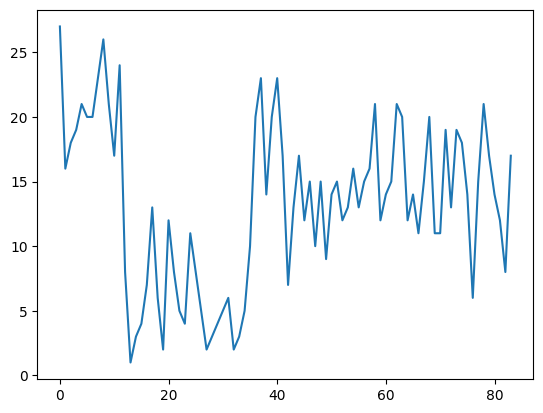

In [6]:
plt.plot(df.series_value)

In [7]:
df = loaded_data.iloc[1,:]
df.series_value

<NumpyExtensionArray>
[10.0,  7.0, 14.0,  9.0, 18.0, 14.0,  8.0, 22.0, 13.0, 14.0, 15.0,  6.0,  2.0,
  8.0,  4.0,  5.0,  4.0,  4.0,  4.0,  2.0,  4.0,  6.0,  7.0,  6.0,  8.0,  2.0,
  5.0,  4.0,  7.0,  6.0,  4.0,  3.0,  5.0,  6.0,  6.0,  7.0, 13.0,  7.0, 15.0,
 12.0, 11.0, 10.0,  9.0, 12.0,  9.0, 16.0,  9.0, 10.0, 14.0, 10.0,  9.0,  7.0,
 15.0,  9.0, 14.0,  7.0,  8.0, 12.0, 18.0, 19.0, 16.0, 15.0, 16.0, 15.0,  8.0,
 19.0, 16.0, 20.0, 11.0, 13.0, 12.0,  8.0, 13.0, 15.0, 13.0,  9.0, 17.0, 22.0,
 11.0, 19.0, 11.0, 12.0, 20.0, 10.0]
Length: 84, dtype: float64

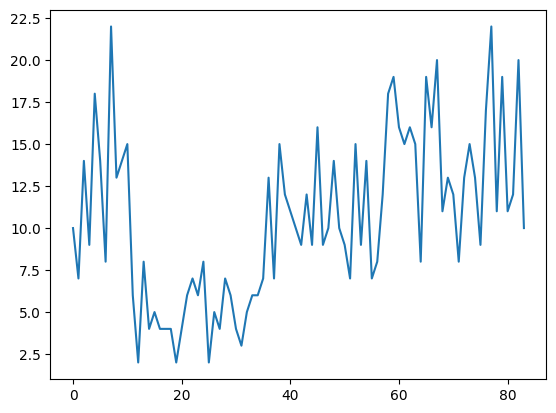

In [8]:
plt.plot(df.series_value)

In [9]:
df = loaded_data.iloc[2,:]
df.series_value

<NumpyExtensionArray>
[194.0, 184.0, 208.0, 190.0, 217.0, 211.0, 212.0, 195.0, 209.0, 181.0, 228.0,
 185.0,  73.0,  74.0, 100.0,  91.0,  91.0, 112.0, 125.0, 113.0,  93.0,  91.0,
  73.0,  72.0,  77.0,  89.0,  87.0,  81.0, 102.0,  74.0, 107.0, 106.0,  78.0,
 100.0,  95.0,  80.0, 183.0, 175.0, 201.0, 210.0, 172.0, 193.0, 206.0, 205.0,
 172.0, 182.0, 185.0, 170.0, 197.0, 189.0, 201.0, 208.0, 199.0, 207.0, 204.0,
 202.0, 206.0, 207.0, 210.0, 228.0, 194.0, 166.0, 198.0, 225.0, 204.0, 183.0,
 205.0, 239.0, 200.0, 191.0, 167.0, 206.0, 205.0, 180.0, 196.0, 192.0, 210.0,
 198.0, 193.0, 190.0, 186.0, 181.0, 198.0, 169.0]
Length: 84, dtype: float64

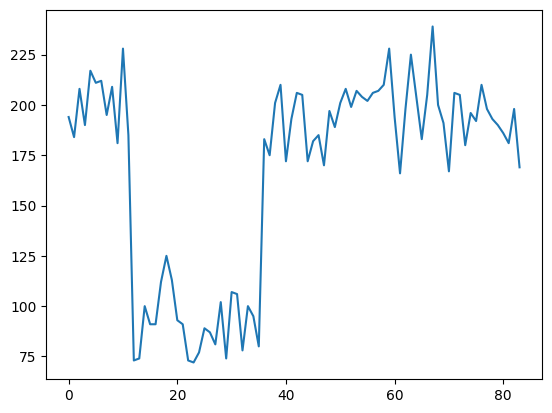

In [10]:
plt.plot(df.series_value)

In [11]:
print('test')

test
